#  0 - Set up

## Imports

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import gc
# --- GAM ---
from pygam import LinearGAM, s, l
np.int = int  # Patch temporaire pour compatibilité pygam
import scipy.sparse
# Patch temporaire : ajoute un attribut `.A` à scipy.sparse matrices
scipy.sparse.csr_matrix.A = property(lambda self: self.toarray())


## Loading Datasets

In [3]:
# VGPM
path_vgpm='/data/rd_exchange/sroyer/SEAPOPYM/daily_pp_papa_1998_2020.nc'
ds_vgpm = xr.open_dataset(path_vgpm,engine='netcdf4')

# --- HYCOM 0.030 kg.m-3 ---

## CbPM 
### Westberry
path_west='/data/rd_exchange/sroyer/SEAPOPYM/NPP/1998_2022_NPP_WESTBERRY_CBPM_25KM_8D.nc'
ds_west = xr.open_dataset(path_west,engine='netcdf4')
### Behrenfeld
path_behr='/data/rd_exchange/sroyer/SEAPOPYM/NPP/1998_2022_NPP_BEHRENFELD_CBPM_25KM_8D.nc'
ds_behr = xr.open_dataset(path_behr,engine='netcdf4')

## CAFE  
path_cafe="/data/rd_exchange/sroyer/SEAPOPYM/NPP/1998_2022_NPP_SILSBE_CAFE_25KM_8D.nc"
ds_cafe = xr.open_dataset(path_cafe,engine='netcdf4')

In [4]:
ds_vgpm=ds_vgpm.drop_vars('day')

In [5]:
# Plankton Micro, Nano, Pico
path_plankton="/data/rd_exchange/sroyer/SEAPOPYM/NPP/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_1748866956346.nc"
ds_plankton=xr.open_dataset(path_plankton)

In [6]:
# Pteropod Biomass Observations
path_obs="/data/rd_exchange/sroyer/SEAPOPYM/time_serie_pter_papa_1998_2020_clean_k_075.nc"
ds_obs = xr.open_dataset(path_obs,engine='netcdf4')
data_pter = (
    np.log10(ds_obs['pteropod_biomass_gm2'])
    .resample(time='ME')
    .mean()
    .dropna(dim='time')
).rename('biomass')# monthly data, log 10 transform

In [7]:
### Temperature
path_temp="/data/rd_exchange/sroyer/SEAPOPYM/daily_temp_papa_1998_2020.nc"
ds_temp = xr.open_dataset(path_temp,engine='netcdf4')

temp = (
    ds_temp['T'].resample(time='ME').mean() 
)

In [8]:
data_pter

<xarray.DataArray 'biomass' (time: 117)> Size: 936B
array([-1.71278315, -1.91917763, -1.85280867, -1.40121632, -1.32338923,
       -0.98200033, -1.99386164, -1.532598  , -1.8449666 , -1.10226856,
       -1.57722602, -1.96636872, -2.75316343, -3.00993101, -0.86579277,
       -0.97894812, -1.67684595, -2.01184095, -2.53657764, -2.79949539,
       -2.26851972, -0.96806192, -0.63952235, -2.5844983 , -2.56684951,
       -1.05018887, -0.95189061, -1.74057726, -1.90448425, -2.00858682,
       -2.02929229, -1.87140697, -0.74446781, -1.45618369, -2.0890729 ,
       -2.41475073, -2.33215911, -1.35808367, -1.62455457, -0.93607643,
       -1.32976228, -1.53737212, -2.18122779, -1.92445142, -2.31078877,
       -2.03849862, -2.21422035, -2.42559277, -2.28223027, -1.38480643,
       -2.87149292, -2.98267221, -1.59265227, -2.24969359, -2.44848199,
       -1.51758254, -1.79162457, -2.43512428, -2.46158114, -2.01400787,
       -1.64843277, -1.30537975, -1.49065508, -2.07369096, -1.31067577,
       -0.75337421, -1.29072998, -1.17678188, -1.75359001, -2.01155452,
       -2.33531514, -1.35992914, -2.70862381, -2.02719966, -2.4026259 ,
       -0.92338816, -3.05072132, -2.04230719, -2.09184009, -1.52137576,
       -1.91933866, -2.29499228, -2.16573392, -0.81885539, -1.33269478,
       -1.34309024, -2.02786938, -2.22479769, -2.3353295 , -2.30170917,
       -2.43153117, -1.4970128 , -2.11746926, -0.85503639, -1.77237059,
       -0.75344034, -0.62591224, -1.99315555, -1.91979763, -1.78306139,
       -1.63797208, -0.69787769, -1.3888912 , -1.94642784, -1.74973276,
       -2.54597909, -1.21150272, -2.33843512, -1.88361687, -1.91847156,
       -1.96202791, -2.68694386, -1.88162248, -1.73805947, -1.69585101,
       -1.84264401, -2.20033745])
Coordinates:
  * time     (time) datetime64[ns] 936B 1998-01-31 1998-02-28 ... 2020-08-31

## Select PAPA location + 1998-2020 to be consitent with obs

In [9]:
### Westberry
ds_west_papa = ds_west.sel(
    lat=slice(48.5, 50.5),
    lon=slice(-130.5, -128.5),
    time=slice("1998", "2020"),
)
ds_west_papa=ds_west_papa.mean(dim=['lon','lat'],skipna=True)

ds_west.close()
gc.collect()

### Behrenfeld
ds_behr_papa = ds_behr.sel(
    lat=slice(48.5, 50.5),
    lon=slice(-130.5, -128.5),
    time=slice("1998", "2020"),
)
ds_behr_papa=ds_behr_papa.mean(dim=['lon','lat'],skipna=True)
ds_behr.close()
gc.collect()

### CAFE  
ds_cafe_papa = ds_cafe.sel(
    lat=slice(48.5, 50.5),
    lon=slice(-130.5, -128.5),
    time=slice("1998", "2020"),
)
ds_cafe_papa=ds_cafe_papa.mean(dim=['lon','lat'],skipna=True)
ds_cafe.close()
gc.collect()

10

In [10]:
ds_plankton_papa = ds_plankton.sel(
    time=slice("1998", "2020"),
)
ds_plankton_papa=ds_plankton_papa.mean(dim=['latitude','longitude'],skipna=True)
ds_plankton.close()
gc.collect()

12

In [11]:
ds_plankton_papa

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 276)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2020-12-01
Data variables:
    MICRO    (time) float32 1kB nan nan nan nan nan ... 0.2302 0.2635 0.2763 nan
    NANO     (time) float32 1kB nan nan nan nan nan ... 0.1634 0.1644 0.1286 nan
    PICO     (time) float32 1kB nan nan nan nan nan ... 0.1413 0.115 0.1256 nan

# 1 - GAM

In [12]:
def decompose_GAM_xr(da):
    """
    Decompose time series from an xarray.DataArray using a GAM model into trend, seasonality, and residuals.
    

    Parameters:
        da (xarray.DataArray): .

    Returns:
        trend_da, season_da, residual_da : xarray.DataArray with the same time dimension as input
    """
    # Moyenne mensuelle
    da_monthly = (
        da
        .resample(time='ME')
        .mean()
        .dropna(dim='time')
    )
    # Convert to DataFrame
    df = da_monthly.dropna(dim='time').to_dataframe(name='value').reset_index()
    
    # Compute float time in days
    df['time_float'] = (df['time'] - df['time'].min()) / np.timedelta64(1, 'D')
    
    # Encode month as sin/cos
    df['month'] = df['time'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)
    
    X = df[['time_float', 'month_sin', 'month_cos']].values
    y = df['value'].values
    
    gam = LinearGAM(s(0, n_splines=80) + l(1) + l(2), fit_intercept=False).fit(X, y)
    
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)
    residuals = y - (trend + season)
    
    # Reconversion en xarray.DataArray
    time_coords = df['time'].values
    trend_da = xr.DataArray(trend, coords={'time': time_coords}, dims='time', name='trend')
    season_da = xr.DataArray(season, coords={'time': time_coords}, dims='time', name='season')
    residual_da = xr.DataArray(residuals, coords={'time': time_coords}, dims='time', name='residual')
    
    return trend_da, season_da, residual_da


In [13]:
vgpm_trend, vgpm_season, vgpm_residuals=decompose_GAM_xr(ds_vgpm["npp"])
west_trend, west_season, west_residuals=decompose_GAM_xr(ds_west_papa["CbPM"])
behr_trend, behr_season, behr_residuals=decompose_GAM_xr(ds_behr_papa["CbPM"])
cafe_trend, cafe_season, cafe_residuals=decompose_GAM_xr(ds_cafe_papa["CAFE"])

In [14]:
pter_trend, pter_season, pter_residuals = decompose_GAM_xr(data_pter)

In [15]:
micro_trend, micro_season, micro_residuals = decompose_GAM_xr(ds_plankton_papa['MICRO'])
nano_trend, nano_season, nano_residuals = decompose_GAM_xr(ds_plankton_papa['NANO'])
pico_trend, pico_season, pico_residuals = decompose_GAM_xr(ds_plankton_papa['PICO'])

In [16]:
temp_trend, temp_season, temp_residuals = decompose_GAM_xr(temp)

In [17]:
def plot_GAM(da,df_trend,df_season,df_residuals):

    plt.figure(figsize=(14, 12))
    plt.subplot(4, 1, 1)
    plt.plot(da['time'], da.values, label='Observé')
    plt.legend()
    # plt.title()

    plt.subplot(4, 1, 2)
    plt.plot(df_trend['time'], df_trend.values, label='Tendance (splines)', color='red')
    plt.legend()
    plt.title('Tendance à long terme')

    plt.subplot(4, 1, 3)
    plt.plot(df_season['time'],df_season.values , label='Saisonnalité (mois)', color='orange')
    plt.legend()
    plt.title('Saisonnalité mensuelle')

    plt.subplot(4, 1, 4)
    plt.hlines(y=0, xmin=df_trend['time'][0],xmax=df_trend['time'][len(df_trend['time'])-1],color='grey')
    plt.plot(df_residuals['time'], df_residuals.values,'o', label='Résidus', color='gray')
    plt.legend()
    plt.title('Résidus')

    plt.tight_layout()
    plt.show()


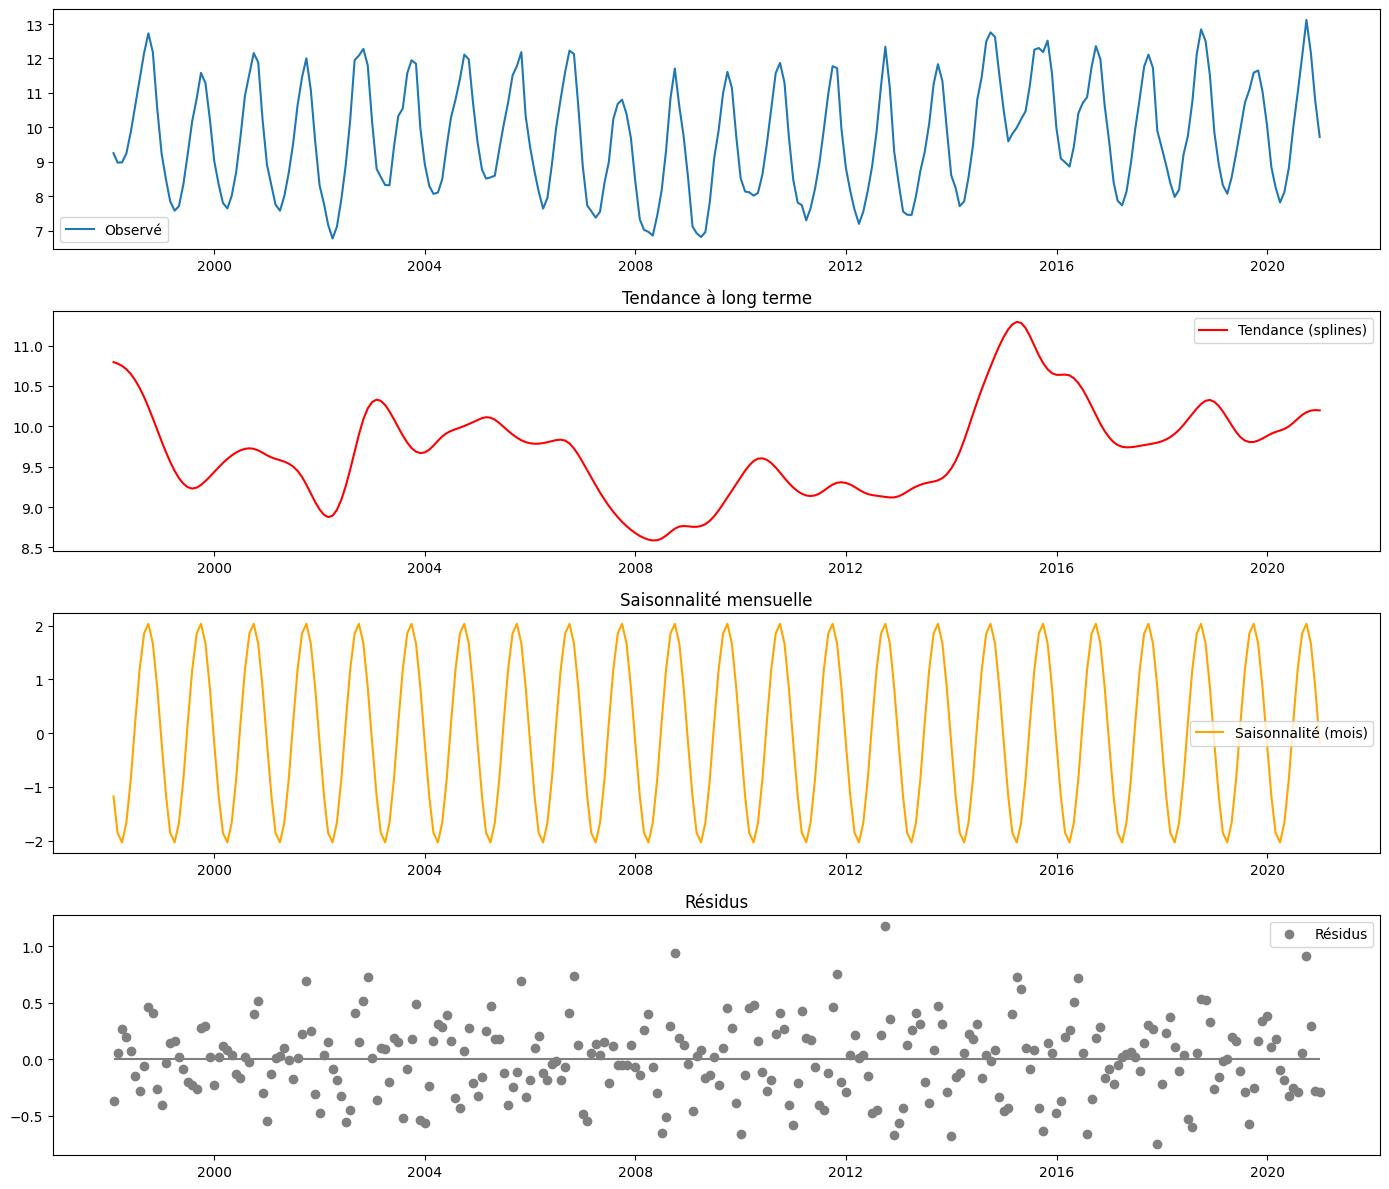

In [18]:
plot_GAM(temp,temp_trend,temp_season,temp_residuals)

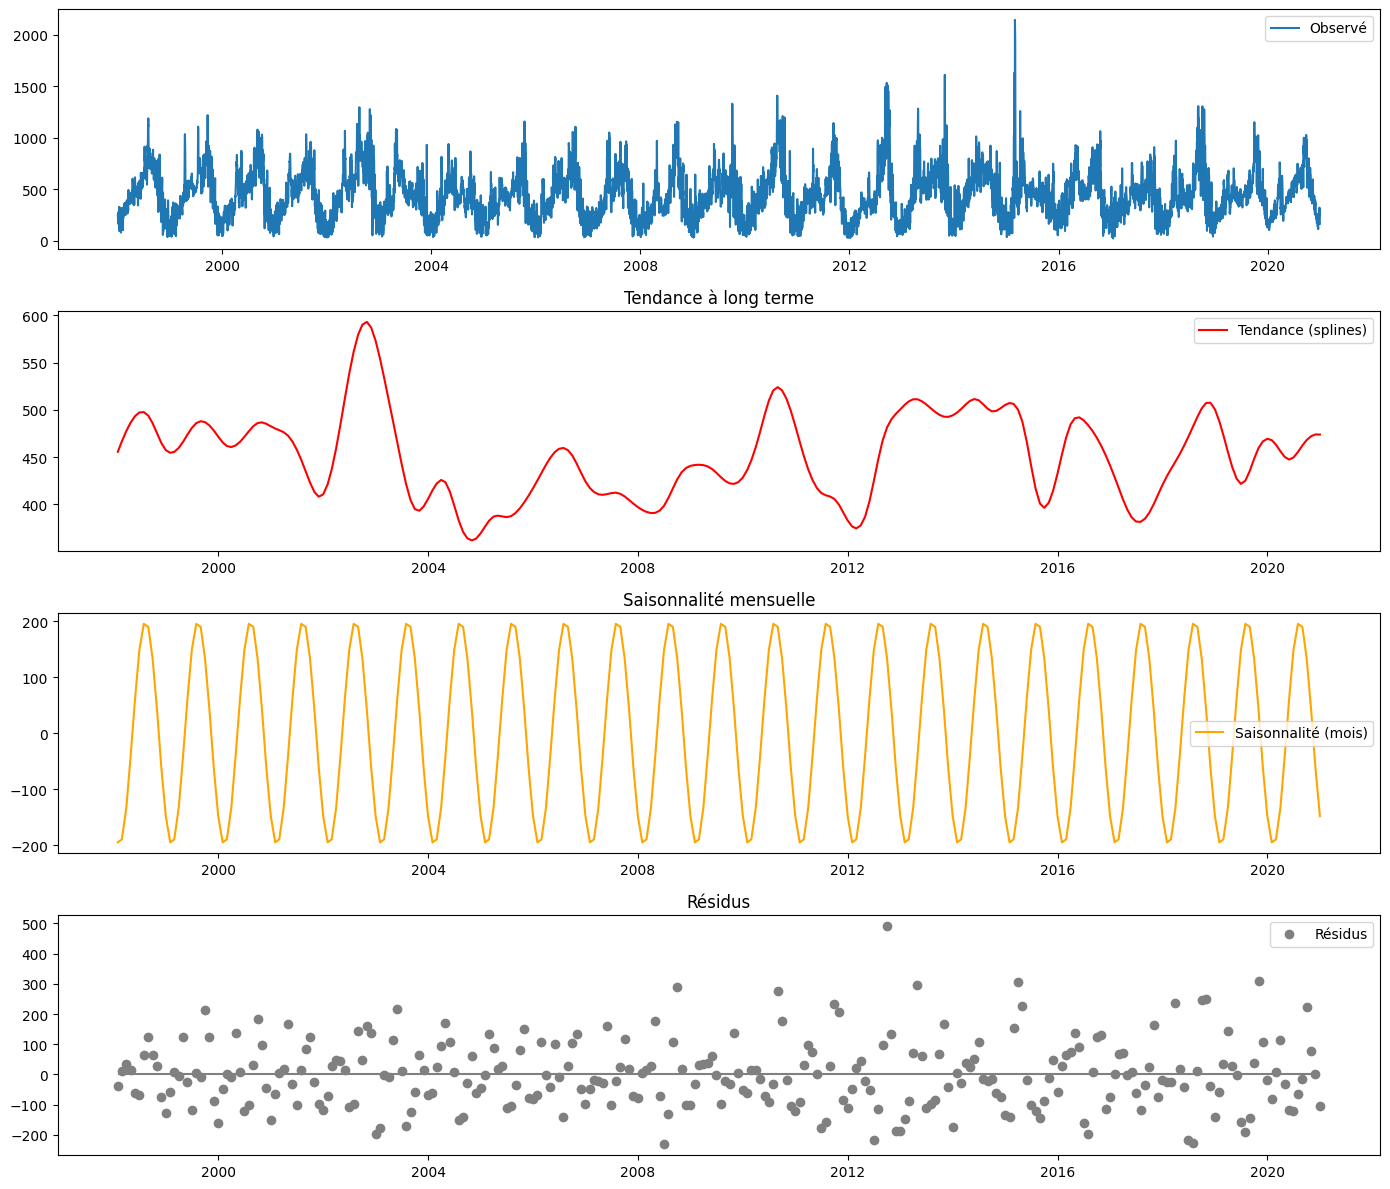

In [19]:
plot_GAM(ds_vgpm['npp'], vgpm_trend,vgpm_season,vgpm_residuals)

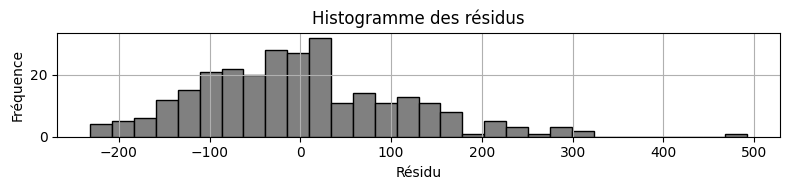

In [20]:
plt.figure(figsize=(8, 2))
plt.hist(vgpm_residuals, bins=30, color='gray', edgecolor='black')
plt.title('Histogramme des résidus')
plt.xlabel('Résidu')
plt.ylabel('Fréquence')
plt.grid(True)
plt.tight_layout()
plt.show()

<div class="alert alert-danger">
    <strong>Warning :</strong> for VGP residuals non gaussien maybe GAM is not appropriate for this NPP product
</div>

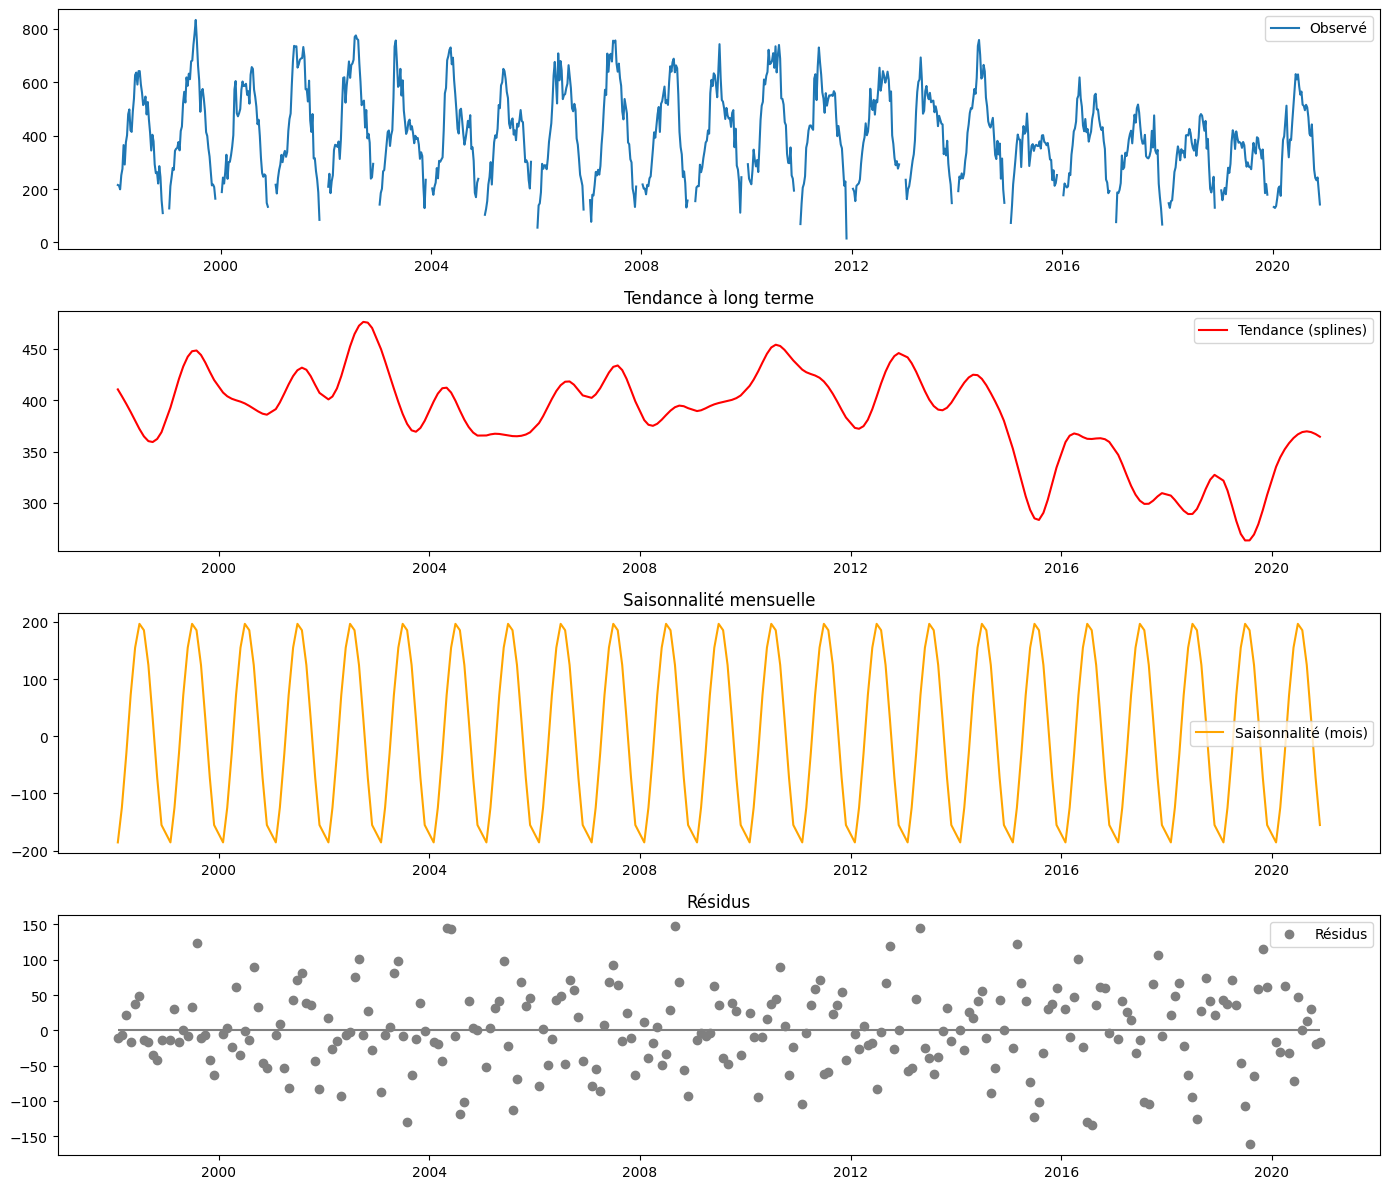

In [21]:
plot_GAM(ds_cafe_papa['CAFE'],cafe_trend,cafe_season,cafe_residuals)

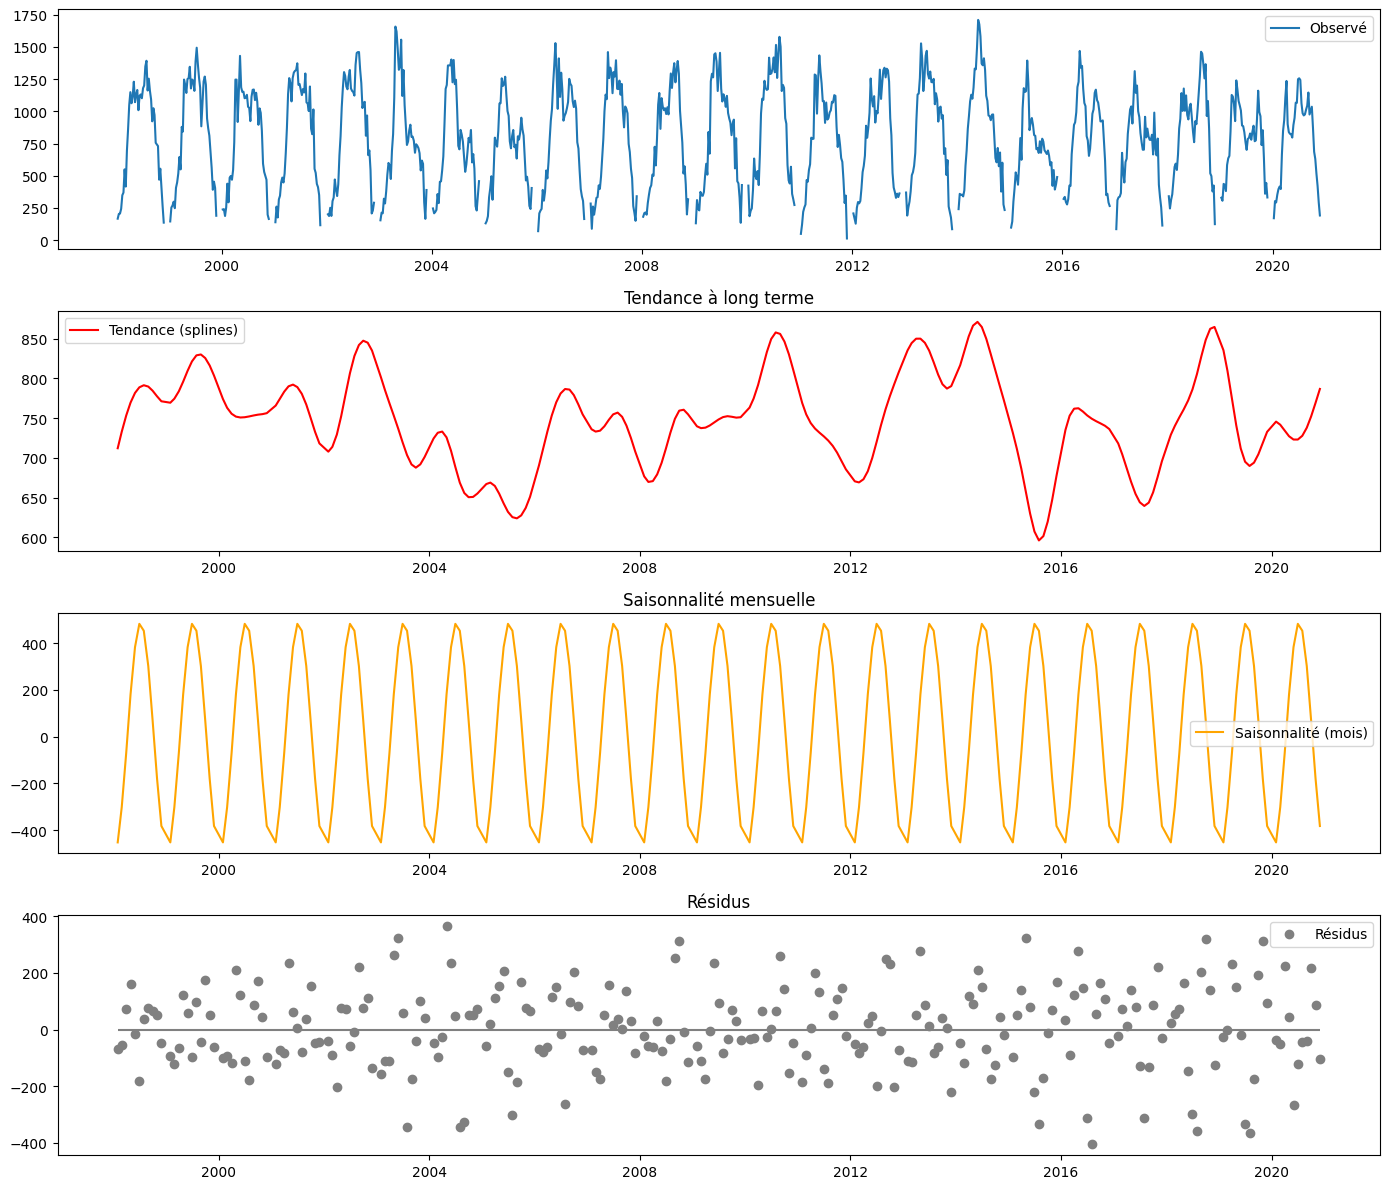

In [22]:
plot_GAM(ds_west_papa['CbPM'],west_trend,west_season,west_residuals)

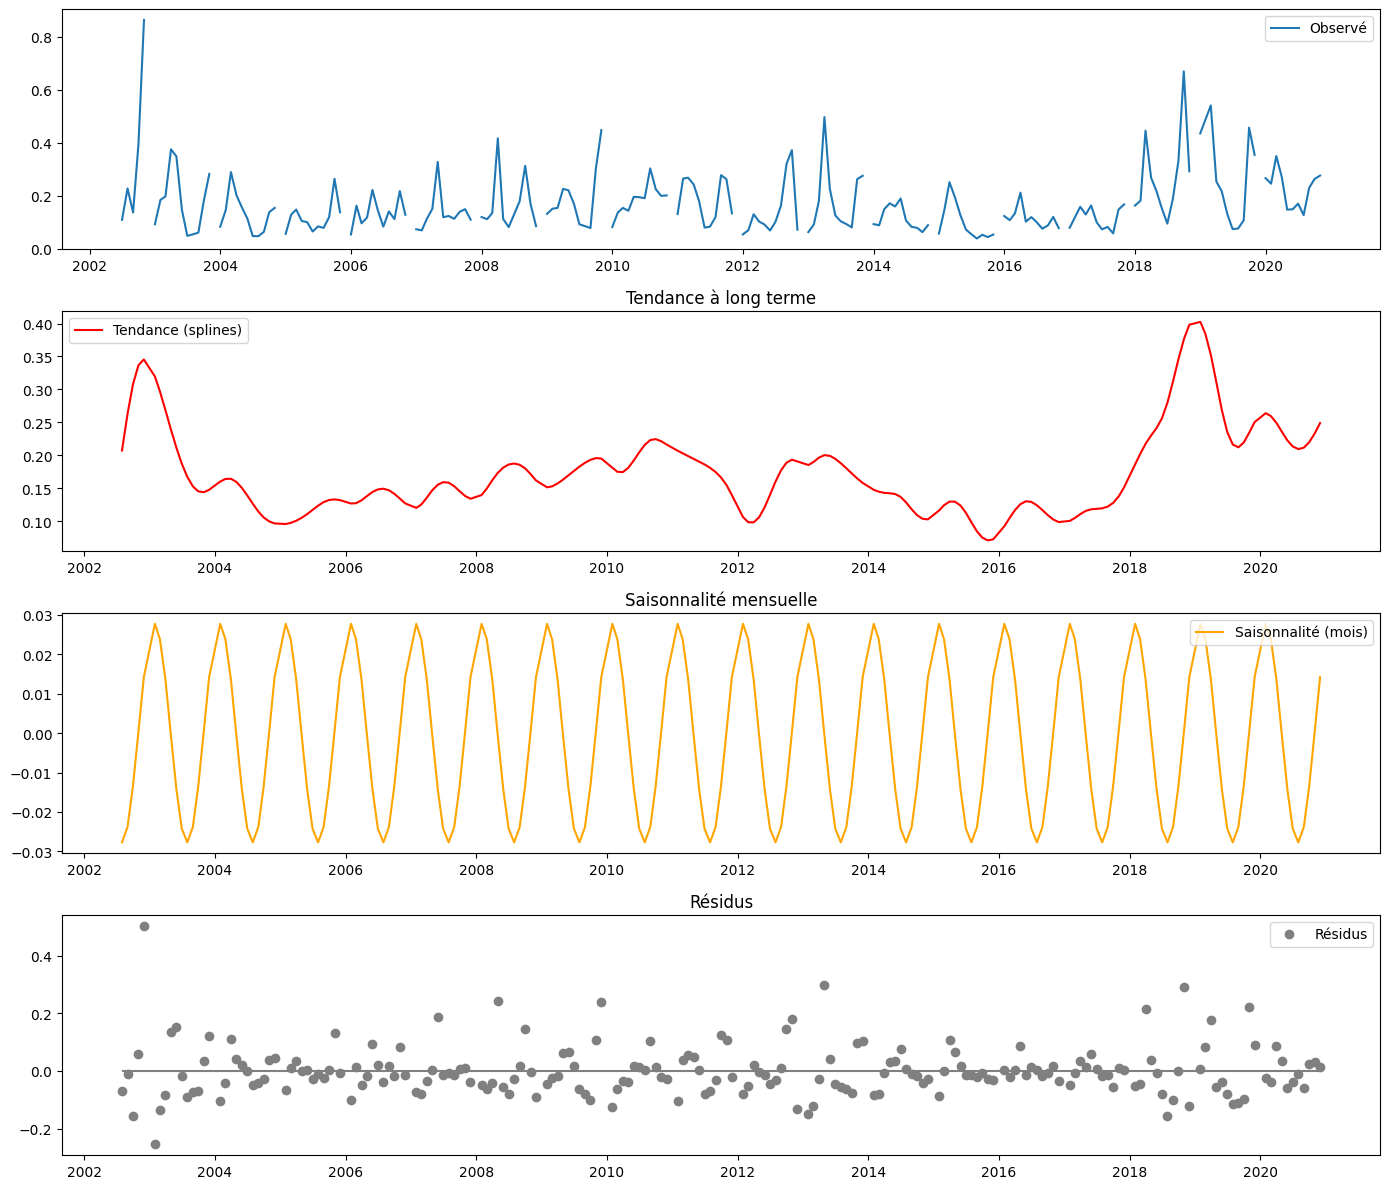

In [23]:
plot_GAM(ds_plankton_papa['MICRO'],micro_trend,micro_season,micro_residuals)


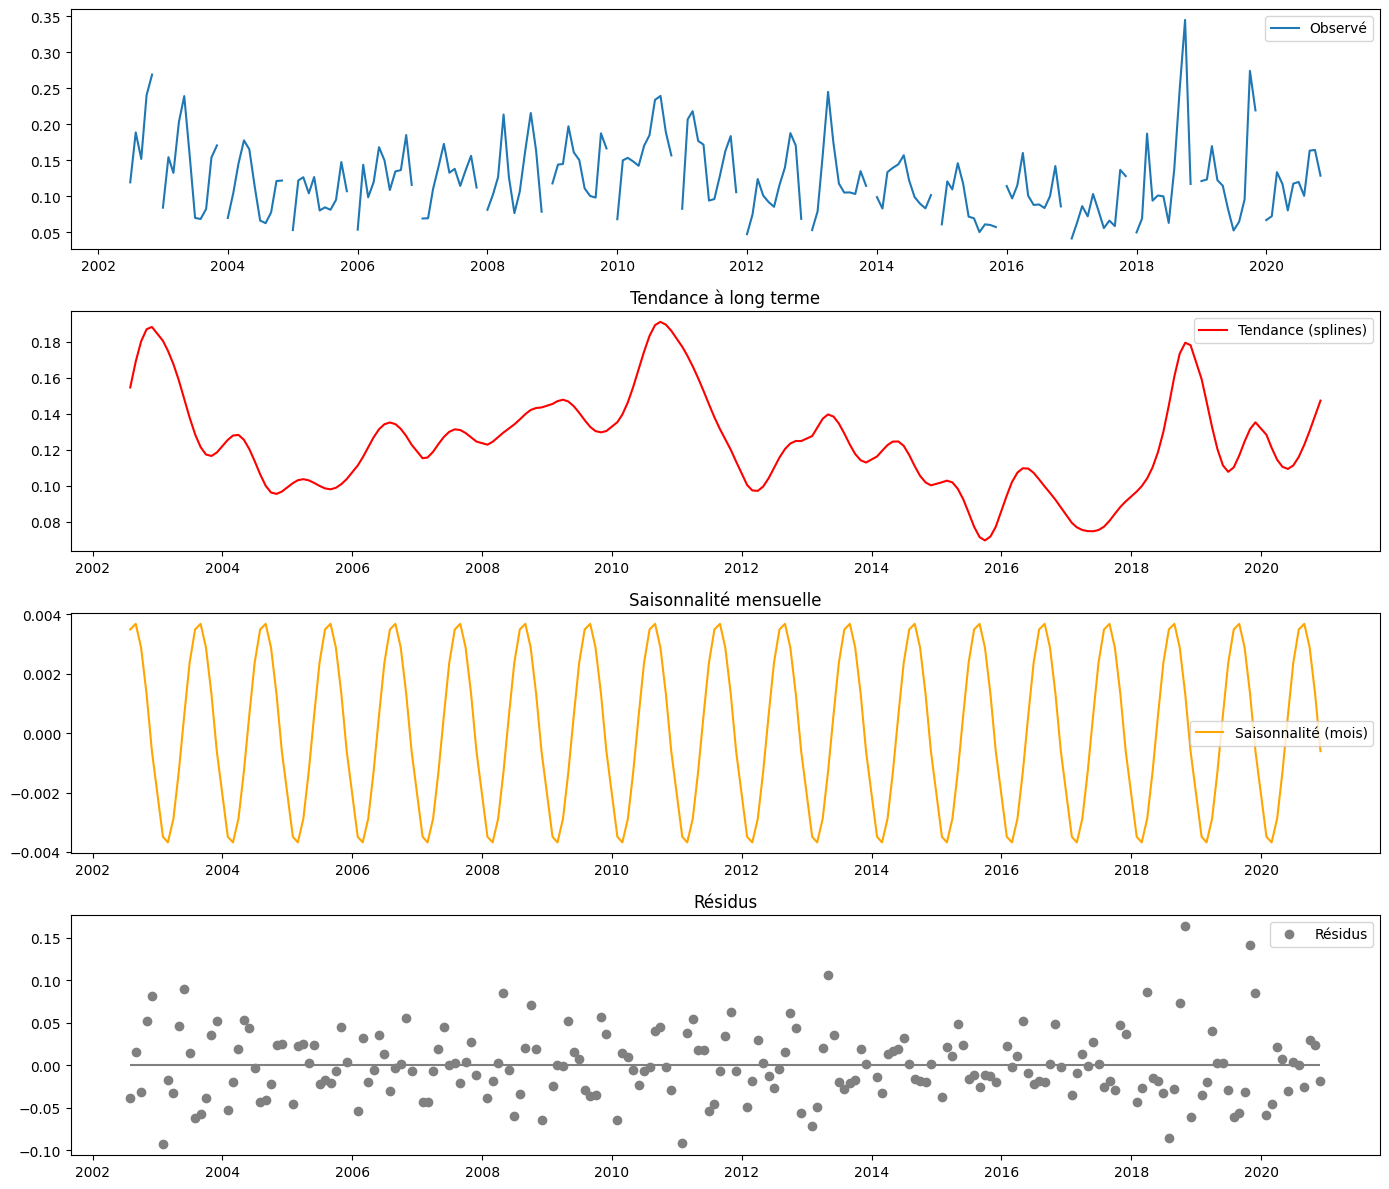

In [24]:
plot_GAM(ds_plankton_papa['NANO'],nano_trend,nano_season,nano_residuals)

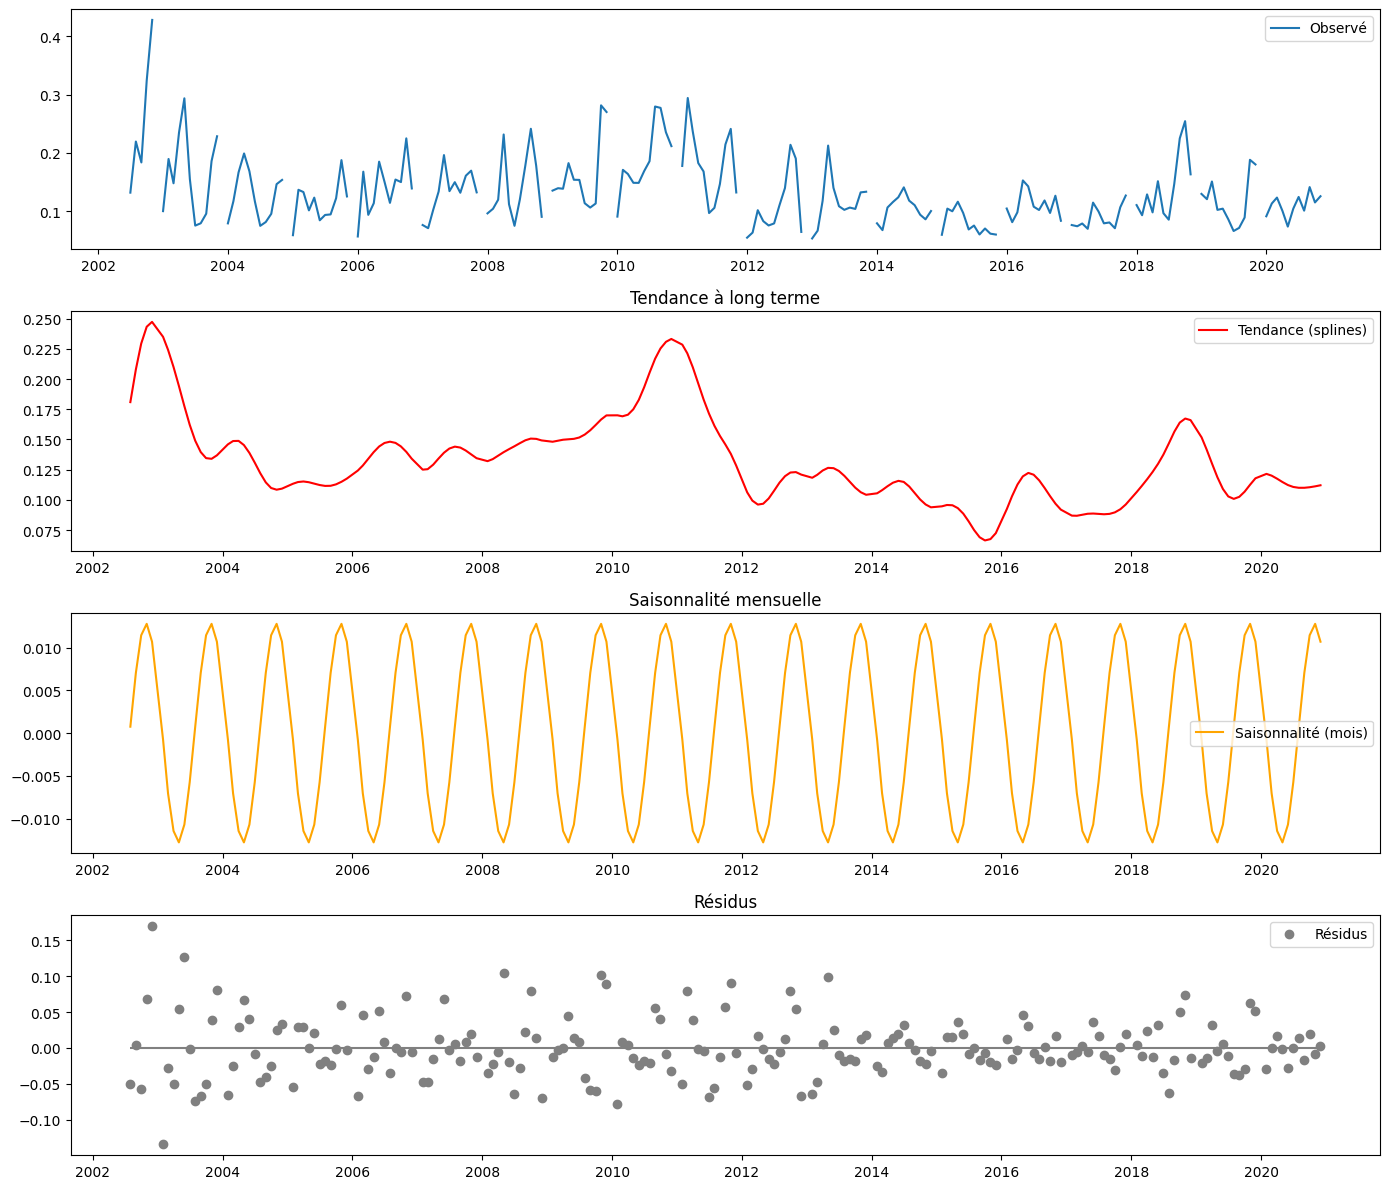

In [25]:
plot_GAM(ds_plankton_papa['PICO'],pico_trend,pico_season,pico_residuals)

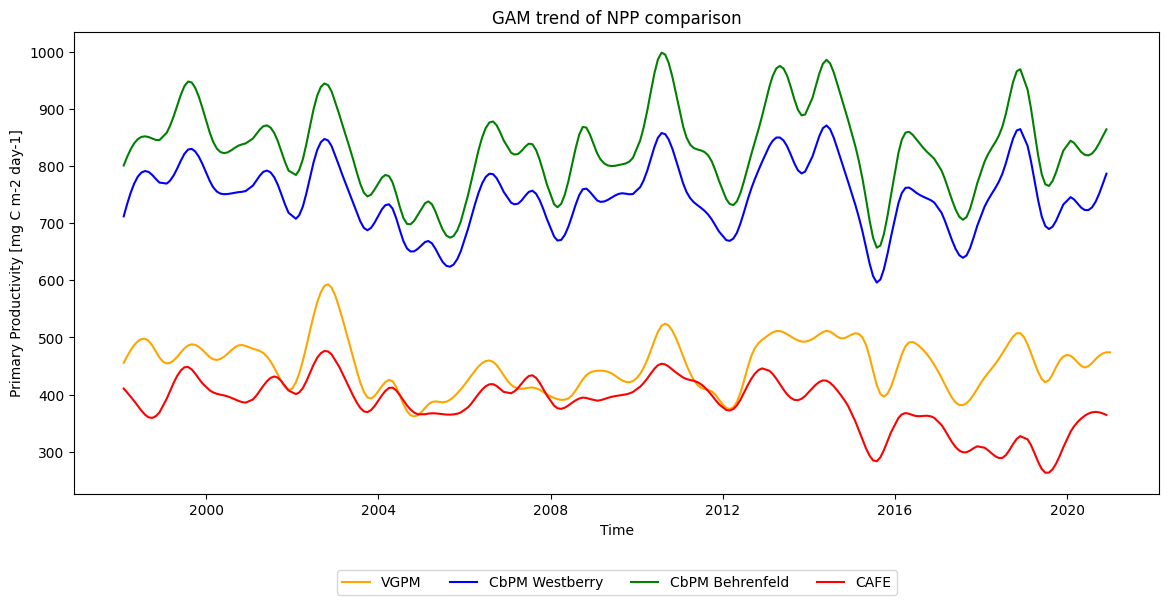

In [26]:
# plot all trends of NPP product
plt.figure(figsize=(14, 6))
plt.title('GAM trend of NPP comparison')
plt.plot(vgpm_trend['time'],vgpm_trend.values, label='VGPM', color='orange')
plt.plot(west_trend['time'],west_trend.values, label='CbPM Westberry', color='blue')
plt.plot(behr_trend['time'],behr_trend.values, label='CbPM Behrenfeld',color='green')
plt.plot(cafe_trend['time'],cafe_trend.values,label='CAFE',color='red')
plt.xlabel('Time')
plt.ylabel('Primary Productivity [mg C m-2 day-1]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

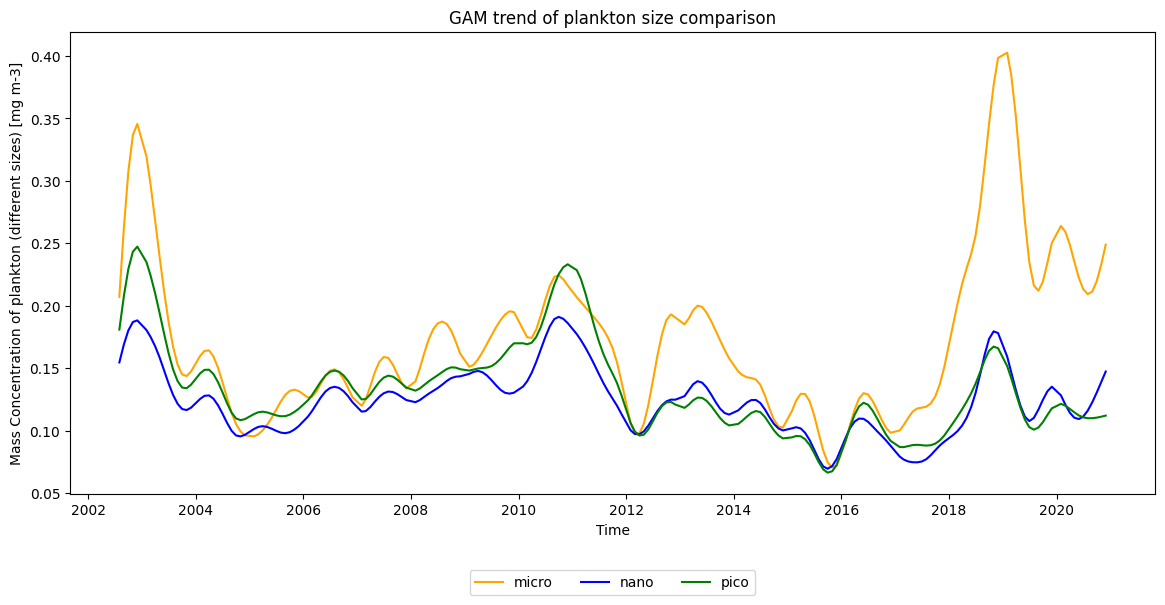

In [27]:
# plot all trends of plankton different size
plt.figure(figsize=(14, 6))
plt.title('GAM trend of plankton size comparison')
plt.plot(micro_trend['time'],micro_trend.values, label='micro', color='orange')
plt.plot(nano_trend['time'],nano_trend.values, label='nano', color='blue')
plt.plot(pico_trend['time'],pico_trend.values, label='pico',color='green')
plt.xlabel('Time')
plt.ylabel('Mass Concentration of plankton (different sizes) [mg m-3]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

In [28]:
vgpm_trend['time']

<xarray.DataArray 'time' (time: 276)> Size: 2kB
array(['1998-01-31T00:00:00.000000000', '1998-02-28T00:00:00.000000000',
       '1998-03-31T00:00:00.000000000', ..., '2020-10-31T00:00:00.000000000',
       '2020-11-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-31 1998-02-28 ... 2020-12-31

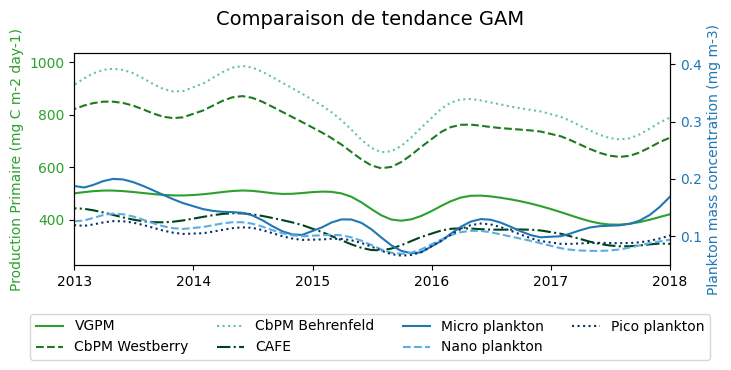

In [29]:
fig, ax1 = plt.subplots(figsize=(7.5, 3))

# Axe principal : NPP (nuances de vert + styles de ligne)
ax1.plot(vgpm_trend['time'], vgpm_trend.values, label='VGPM', color='#2ca02c', linestyle='-')           # vert vif
ax1.plot(west_trend['time'], west_trend.values, label='CbPM Westberry', color='#1f7a1f', linestyle='--') # vert fonc�, tirets
ax1.plot(behr_trend['time'], behr_trend.values, label='CbPM Behrenfeld', color='#66c2a5', linestyle=':') # vert p�le, pointill�s
ax1.plot(cafe_trend['time'], cafe_trend.values, label='CAFE', color='#00441b', linestyle='-.')           # vert tr�s fonc�, tirets-points
ax1.set_ylabel("Production Primaire (mg C m-2 day-1)", color="tab:green")
ax1.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2018-01-01'))
ax1.tick_params(axis='y', labelcolor="tab:green")

# Deuxième axe Y : Plancton (nuances de bleu + styles de ligne)
ax2 = ax1.twinx()
ax2.plot(micro_trend["time"], micro_trend.values, color='#1f77b4', linestyle='-', label="Micro plankton")  # bleu classique
ax2.plot(nano_trend["time"], nano_trend.values, color='#5dade2', linestyle='--', label="Nano plankton")     # bleu clair
ax2.plot(pico_trend["time"], pico_trend.values, color='#08306b', linestyle=':', label="Pico plankton")      # bleu fonc�
ax2.set_ylabel("Plankton mass concentration (mg m-3)", color="tab:blue")
ax2.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2018-01-01'))
ax2.tick_params(axis='y', labelcolor="tab:blue")


# Titre
fig.suptitle("Comparaison de tendance GAM", fontsize=14)

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
# lines_3, labels_3 = ax3.get_legend_handles_labels()
fig.legend(lines_1 + lines_2 ,
           labels_1 + labels_2 ,
           loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)

plt.tight_layout()
plt.show()


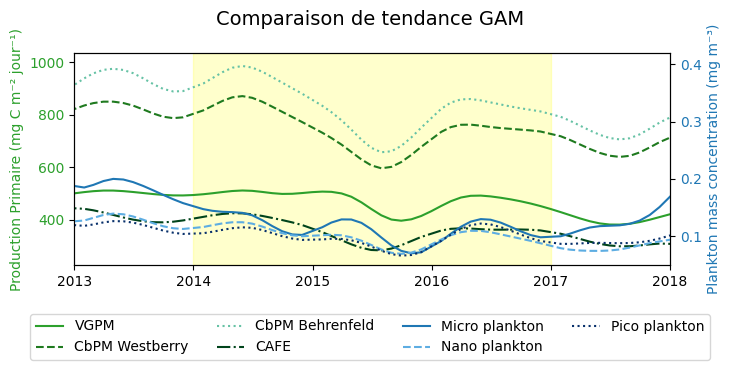

In [30]:
fig, ax1 = plt.subplots(figsize=(7.5, 3))

# Zone jaune pour 2014-2016
ax1.axvspan(np.datetime64('2014-01-01'), np.datetime64('2016-12-31'), color='yellow', alpha=0.2)

# Axe principal : NPP (nuances de vert + styles de ligne)
ax1.plot(vgpm_trend['time'], vgpm_trend.values, label='VGPM', color='#2ca02c', linestyle='-')           
ax1.plot(west_trend['time'], west_trend.values, label='CbPM Westberry', color='#1f7a1f', linestyle='--') 
ax1.plot(behr_trend['time'], behr_trend.values, label='CbPM Behrenfeld', color='#66c2a5', linestyle=':') 
ax1.plot(cafe_trend['time'], cafe_trend.values, label='CAFE', color='#00441b', linestyle='-.')           
ax1.set_ylabel("Production Primaire (mg C m⁻² jour⁻¹)", color="tab:green")
ax1.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2018-01-01'))
ax1.tick_params(axis='y', labelcolor="tab:green")

# Deuxième axe Y : Plancton (nuances de bleu + styles de ligne)
ax2 = ax1.twinx()
ax2.plot(micro_trend["time"], micro_trend.values, color='#1f77b4', linestyle='-', label="Micro plankton")  
ax2.plot(nano_trend["time"], nano_trend.values, color='#5dade2', linestyle='--', label="Nano plankton")     
ax2.plot(pico_trend["time"], pico_trend.values, color='#08306b', linestyle=':', label="Pico plankton")      
ax2.set_ylabel("Plankton mass concentration (mg m⁻³)", color="tab:blue")
ax2.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2018-01-01'))
ax2.tick_params(axis='y', labelcolor="tab:blue")

# Titre
fig.suptitle("Comparaison de tendance GAM", fontsize=14)

# Légende combinée
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
fig.legend(lines_1 + lines_2,
           labels_1 + labels_2,
           loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)

plt.tight_layout()
plt.show()



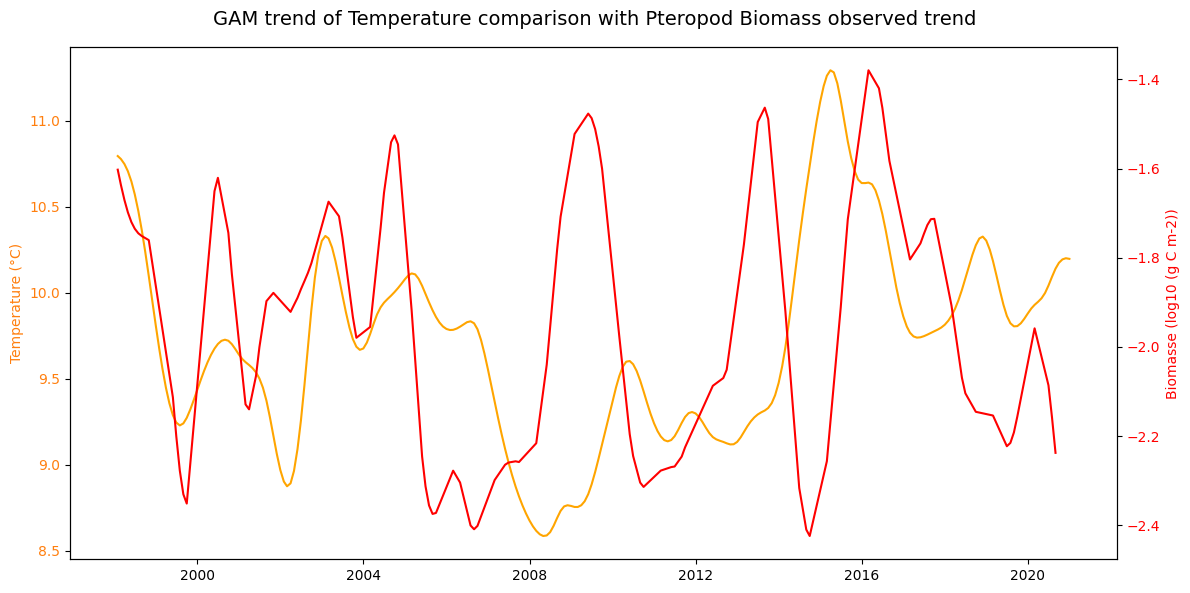

In [28]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe principal : Temperature
ax1.plot(temp_trend['time'], temp_trend.values, label='Temperature', color='orange', linestyle='-')           
ax1.set_ylabel("Temperature (°C)", color="tab:orange")
ax1.tick_params(axis='y', labelcolor="tab:orange")


# 2e axe Y : Biomasse (rouge + style unique)
ax2 = ax1.twinx()
ax2.plot(pter_trend["time"], pter_trend.values, label="log10 Biomasse (g C m-2)", color="red", linestyle='-')
ax2.set_ylabel("Biomasse (log10 (g C m-2))", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Titre
fig.suptitle("GAM trend of Temperature comparison with Pteropod Biomass observed trend", fontsize=14)

# Légende combinée
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()

# fig.legend(lines_1 + lines_2,
#            labels_1 + labels_2,
#            loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)

plt.tight_layout()
plt.show()


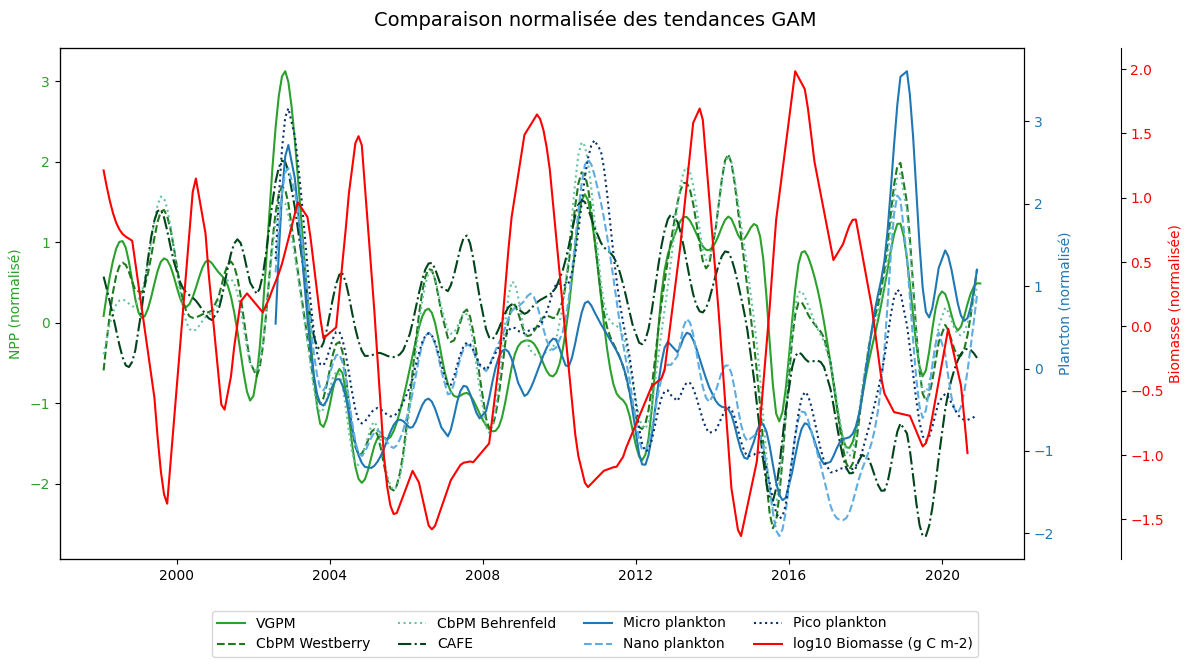

In [29]:
def normalize(da):
    return (da - da.mean()) / da.std()

# Normalisation des séries
vgpm_norm   = normalize(vgpm_trend)
west_norm   = normalize(west_trend)
behr_norm   = normalize(behr_trend)
cafe_norm   = normalize(cafe_trend)
micro_norm  = normalize(micro_trend)
nano_norm   = normalize(nano_trend)
pico_norm   = normalize(pico_trend)
pter_norm   = normalize(pter_trend)

# Tracé
fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe principal : NPP (nuances de vert + styles de ligne)
ax1.plot(vgpm_norm['time'], vgpm_norm.values, label='VGPM', color='#2ca02c', linestyle='-')
ax1.plot(west_norm['time'], west_norm.values, label='CbPM Westberry', color='#1f7a1f', linestyle='--')
ax1.plot(behr_norm['time'], behr_norm.values, label='CbPM Behrenfeld', color='#66c2a5', linestyle=':')
ax1.plot(cafe_norm['time'], cafe_norm.values, label='CAFE', color='#00441b', linestyle='-.')

# Deuxiéme axe Y : Plancton (nuances de bleu + styles de ligne)
ax2 = ax1.twinx()
ax2.plot(micro_norm["time"], micro_norm.values, color='#1f77b4', linestyle='-', label="Micro plankton")
ax2.plot(nano_norm["time"], nano_norm.values, color='#5dade2', linestyle='--', label="Nano plankton")
ax2.plot(pico_norm["time"], pico_norm.values, color='#08306b', linestyle=':', label="Pico plankton")

# Troisiéme axe Y : Biomasse
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(pter_norm["time"], pter_norm.values, label="log10 Biomasse (g C m-2)", color="red", linestyle='-')

# Titre et �tiquettes
fig.suptitle("Comparaison normalisée des tendances GAM", fontsize=14)
ax1.set_ylabel("NPP (normalisé)", color="tab:green")
ax2.set_ylabel("Plancton (normalisé)", color="tab:blue")
ax3.set_ylabel("Biomasse (normalisée)", color="red")
ax1.tick_params(axis='y', labelcolor="tab:green")
ax2.tick_params(axis='y', labelcolor="tab:blue")
ax3.tick_params(axis='y', labelcolor="red")

# L�gende combin�e
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
fig.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3,
           loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=4)

plt.tight_layout()
plt.show()



# 2 - Correlation btw biomass and NPP

## 2 - a. Pearson correlation

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Pearson coefficient :</strong> <br> 0 no correlation <br> 1 positive correlation <br> -1 negative correlation
</div>

In [30]:
from scipy.stats import pearsonr

datasets_trend = [vgpm_trend, west_trend, behr_trend, cafe_trend, micro_trend, nano_trend, pico_trend]
labels = ["VGPM", "CbPM Westberry", "CbPM Behrenfeld", "CAFE", "Micro", "Nano", "Pico"]

for dataset, label in zip(datasets_trend, labels):
    # Aligner temporellement les deux séries
    ds_aligned, pter_aligned = xr.align(dataset, pter_trend, join="inner")
    
    # Extraire les valeurs (sans NaN)
    mask = ~np.isnan(ds_aligned.values) & ~np.isnan(pter_aligned.values)
    x = ds_aligned.values[mask]
    y = pter_aligned.values[mask]
    
    # Calculer la corrélation seulement si les deux tableaux ont assez de points
    if len(x) > 1:
        coef, pvalue = pearsonr(x, y)
        print(f"{label}: r = {coef:.2f}, p = {pvalue:.3e}")
    else:
        print(f"{label}: pas assez de données après alignement.")


VGPM: r = 0.04, p = 6.718e-01
CbPM Westberry: r = -0.09, p = 3.083e-01
CbPM Behrenfeld: r = -0.16, p = 8.906e-02
CAFE: r = -0.11, p = 2.232e-01
Micro: r = -0.07, p = 4.946e-01
Nano: r = -0.15, p = 1.676e-01
Pico: r = -0.08, p = 4.399e-01


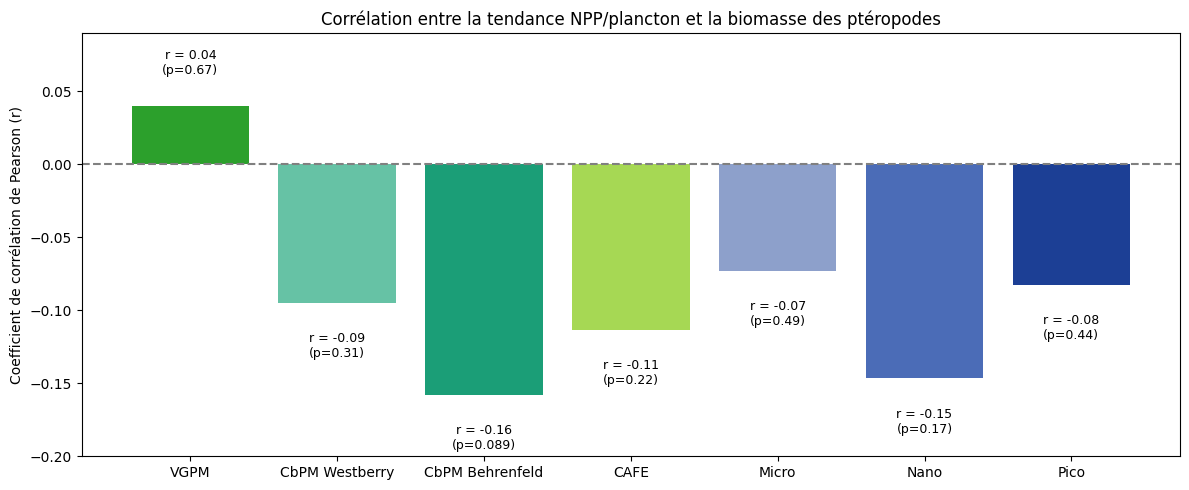

In [31]:
# Données
datasets_trend = [vgpm_trend, west_trend, behr_trend, cafe_trend, micro_trend, nano_trend, pico_trend]
labels = ["VGPM", "CbPM Westberry", "CbPM Behrenfeld", "CAFE", "Micro", "Nano", "Pico"]
colors = ["#2ca02c", "#66c2a5", "#1b9e77", "#a6d854", "#8da0cb", "#4b6cb7", "#1c3f95"]  # verts et bleus
correlations = []
pvalues = []

# Calcul des corrélations
for dataset in datasets_trend:
    ds_aligned, pter_aligned = xr.align(dataset, pter_trend, join="inner")
    mask = ~np.isnan(ds_aligned.values) & ~np.isnan(pter_aligned.values)
    x = ds_aligned.values[mask]
    y = pter_aligned.values[mask]

    if len(x) > 1:
        coef, pval = pearsonr(x, y)
    else:
        coef, pval = np.nan, np.nan
    correlations.append(coef)
    pvalues.append(pval)

# Affichage
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(labels, correlations, color=colors)
ax.axhline(0, color='gray', linestyle='--')
ax.set_ylabel("Coefficient de corrélation de Pearson (r)")
ax.set_title("Corrélation entre la tendance NPP/plancton et la biomasse des ptéropodes")

# Annoter les barres avec les valeurs r
for bar, coef, pval in zip(bars, correlations, pvalues):
    label = f"r = {coef:.2f}\n(p={pval:.2g})" if not np.isnan(coef) else "NA"
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02*np.sign(height), label,
            ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

ax.set_ylim(-0.2,0.09)
plt.tight_layout()
plt.show()


<div class="alert alert-danger">
    <strong>Warning :</strong> in a Pearson test, the null hypothesis is "samples are uncorrelated ..." we can rejet H0 if the pvalue is less than 0.05.
    As the p-values is larger than 0.05, we cannot conclude.
</div>

## 2 - b. Spearman Correlation

<div style="padding: 10px; border-radius: 5px; background-color: #cce5ff; color: #004085; border-left: 5px solid #007bff;">
    <strong>Spearman coefficient :</strong> for non linear but monotonus relationships
</div>

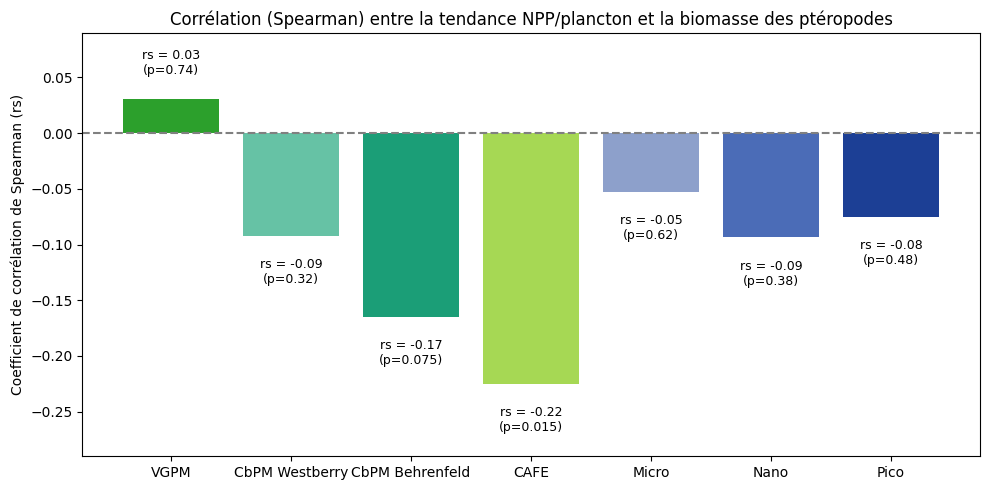

In [32]:
from scipy.stats import spearmanr

# Données
datasets_trend = [vgpm_trend, west_trend, behr_trend, cafe_trend, micro_trend, nano_trend, pico_trend]
labels = ["VGPM", "CbPM Westberry", "CbPM Behrenfeld", "CAFE", "Micro", "Nano", "Pico"]
colors = ["#2ca02c", "#66c2a5", "#1b9e77", "#a6d854", "#8da0cb", "#4b6cb7", "#1c3f95"]  # verts et bleus
correlations = []
pvalues = []

# Calcul des corrélations de Spearman
for dataset in datasets_trend:
    ds_aligned, pter_aligned = xr.align(dataset, pter_trend, join="inner")
    mask = ~np.isnan(ds_aligned.values) & ~np.isnan(pter_aligned.values)
    x = ds_aligned.values[mask]
    y = pter_aligned.values[mask]

    if len(x) > 1:
        coef, pval = spearmanr(x, y)
    else:
        coef, pval = np.nan, np.nan
    correlations.append(coef)
    pvalues.append(pval)

# Affichage
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(labels, correlations, color=colors)
ax.axhline(0, color='gray', linestyle='--')
ax.set_ylabel("Coefficient de corrélation de Spearman (rs)")
ax.set_title("Corrélation (Spearman) entre la tendance NPP/plancton et la biomasse des ptéropodes")

# Annoter les barres
for bar, coef, pval in zip(bars, correlations, pvalues):
    label = f"rs = {coef:.2f}\n(p={pval:.2g})" if not np.isnan(coef) else "NA"
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02*np.sign(height), label,
            ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
ax.set_ylim(-0.29,0.09)
plt.tight_layout()
plt.show()


## 2 - c Cross Corelation

Used in signal processing, it is a measure of the similarity of two signals.

In [33]:
datasets_trend = [vgpm_trend, west_trend, behr_trend, cafe_trend, micro_trend, nano_trend, pico_trend]
labels = ["VGPM", "CbPM Westberry", "CbPM Behrenfeld", "CAFE", "Micro", "Nano", "Pico"]
colors = ["#2ca02c", "#66c2a5", "#1b9e77", "#a6d854", "#8da0cb", "#4b6cb7", "#1c3f95"]
linestyles=['-','--',':','-.','-','--',':']

In [34]:
from scipy.signal import correlate, correlation_lags

def plot_cross_correlation(datasets, labels, linestyles, target):
    """
    Calcule et trace la cross-corrélation entre une liste de s�éries temporelles 
    et une cible (ex: biomasse).
    
    Paramétres :
    - datasets : liste de xarray.DataArray
    - labels : noms à afficher sur les courbes
    - target : xarray.DataArray à corréler avec les datasets
    - max_lag_days : décalage maximum (positif et négatif) à considérer pour la corrélation
    
    Affiche un graphique matplotlib des fonctions de cross-corrélation.
    """
    plt.figure(figsize=(10, 6))
    target_times=pd.date_range(
        start="1/1/1998",
        end="12/31/2020",
        freq="ME"
    )
    for ds, label, linestyle in zip(datasets, labels, linestyles):
        # Interpolation et alignement et nettoyage 
        ds_interp=ds.interp(time=target_times)
        target_interp=target.interp(time=target_times)
        ds_aligned, target_aligned = xr.align(ds_interp, target_interp, join="inner")
        x = ds_aligned.values
        y = target_aligned.values
        mask = ~np.isnan(x) & ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        
        if len(x) < 2:
            print(f"{label}: série trop courte pour la corrélation.")
            continue
        
        # Normalisation
        x = (x - np.mean(x)) / np.std(x)
        y = (y - np.mean(y)) / np.std(y)
        
        # Cross-corrélation
        corr = correlate(x, y, mode='full')
        lags = correlation_lags(x.size,y.size,mode="full")
        # lag=lags[np.argmax(corr)]
        

        # Normalisation de la corrélation 
        corr /= np.max(np.abs(corr))
        
        plt.plot(lags, corr, label=label, linestyle=linestyle)
    
    # plt.axvline(0, color='gray', linestyle='--')
    plt.xlabel("Lag (months)")
    plt.xlim(-36,36)
    plt.ylabel("Normalised Cross Correlation")
    plt.title("Cross correlation btw food availability proxy and pteropod biomass")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


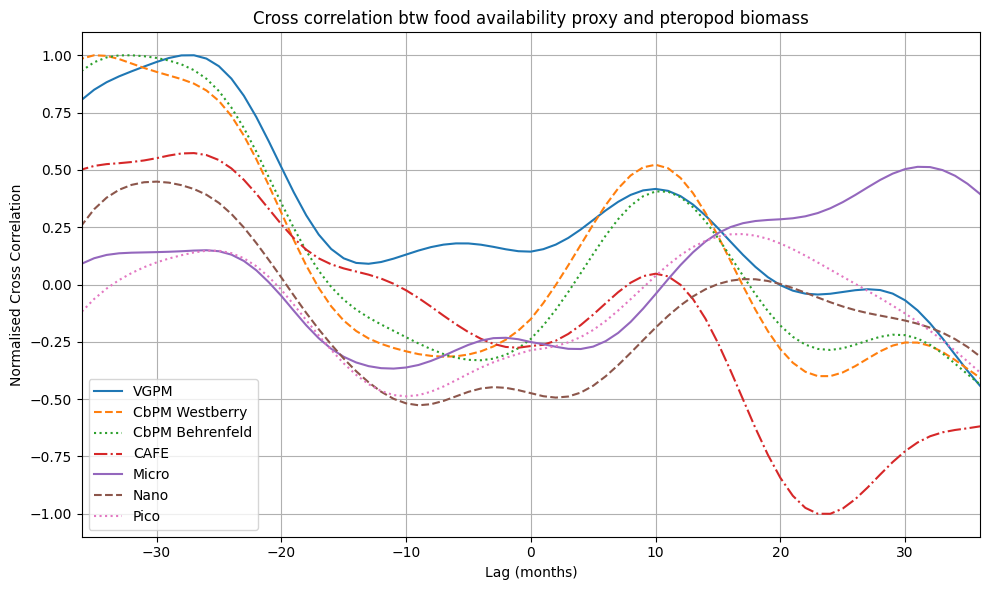

In [35]:
plot_cross_correlation(datasets_trend, labels, linestyles, pter_trend) 

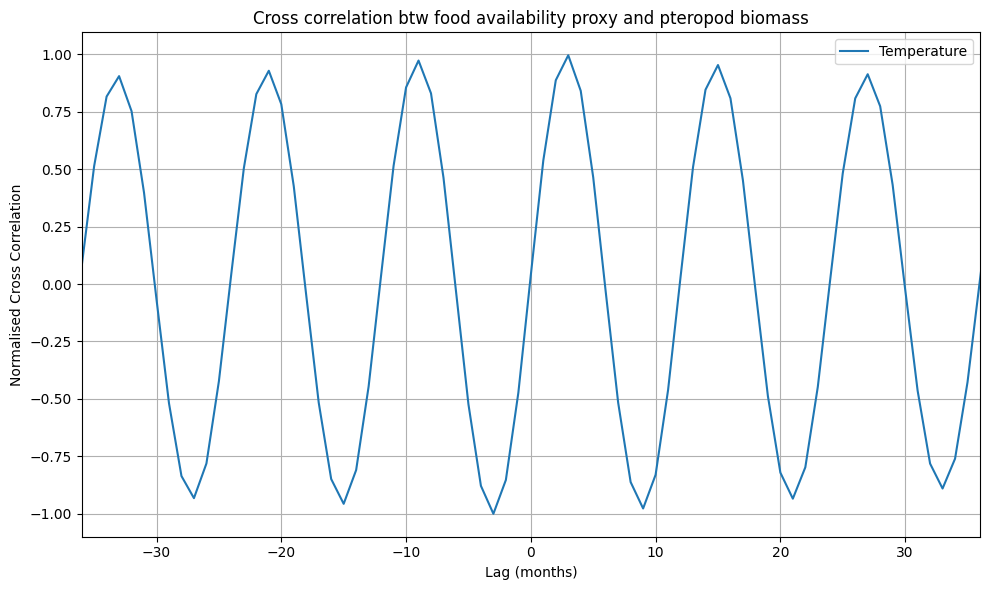

In [41]:
plot_cross_correlation([temp_season],['Temperature'], ['-'], pter_season)

In [38]:
datasets_bruts = [ds_vgpm['npp'], ds_west_papa['CbPM'], 
                  ds_behr_papa['CbPM'], ds_cafe_papa["CAFE"], 
                  ds_plankton_papa["MICRO"], ds_plankton_papa['NANO'], 
                  ds_plankton_papa["PICO"]]

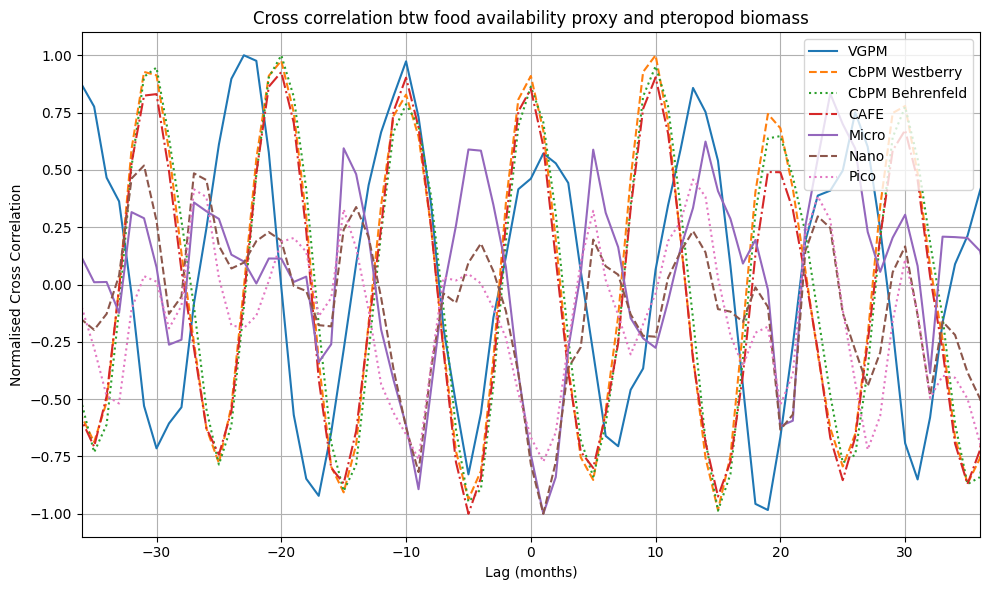

In [39]:
plot_cross_correlation(datasets_bruts, labels, linestyles, data_pter) 